In [19]:
"""
Imports
"""
import numpy as np
from hlxon_hdf5io import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import  train_test_split
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from filters.HelixonKalmanFilter import *
from metrics import *
import time
from model.spiral_model import *



"""
Load Data
"""
dataset = readAll()

In [20]:
# creating spiral model
spiral_pitch = 4.2 #m
spiral_radius = 8 #m
path_width = 2.4 #m
Spiral = Spiral(spiral_pitch, spiral_radius, path_width)

# Evaluation of Wi-Fi based Random Forest Implementation

In [21]:
"""
Load Model
"""
from pickle import load
with open(os.path.join("model", "wifi_model.pkl"), "rb") as f:
    best_rf = load(f)

"""
Load BSSID mapping
"""
with open(os.path.join("model", "bssid_map.pkl"), "rb") as f:
    bssidMap = load(f)



In [22]:


"""
Preprocess Data and Split Data
"""
Xs = []
ys = []

for sequence in dataset:
    _, _, _, _, _, _, wifidata, gt_timestamp, gt_position, _ = sequence
    ts = np.array([row[0] for row in wifidata])
    cnts = np.array([row[1] for row in wifidata])
    bssids = np.array([[np.argmax(row[i].decode() == bssidMap) for i in range(2, len(row), 2)] for row in wifidata]) # mapped to indices here
    rssis = np.array([[row[i] for i in range(3, len(row), 2)]  for row in wifidata])

    Z = 2
    positions = np.array(gt_position)[:, :]
    gt_ts = np.array(gt_timestamp)

    N = len(wifidata)

    # interpolate over timestamps
    lerped_positions = np.zeros((N, 3))
    for i in range(N):
        if ts[i] in gt_ts:
            lerped_positions[i] = positions[np.argmax(gt_ts == ts[i])]
        else:
            # lerp
            ix_2 = np.argmax(gt_ts > ts[i])
            ix_1 = gt_ts.shape[0] - np.argmax(np.flip(gt_ts, axis=0) < ts[i]) - 1
            

            # lerp formula: y12 = y1 + (t12 - t1) * (y2-y1)/(t2-t1 + stability epsilon)
            lerped_positions[i] = positions[ix_1] + (ts[i]-gt_ts[ix_1])*(positions[ix_2] - positions[ix_1])/(gt_ts[ix_2] - gt_ts[ix_1] + 1e-9)


    # define inputs and outputs
    Xi = np.ones((N, bssidMap.shape[0])) * -100
    rssis = rssis.reshape((N, -1))
    for i in range(N):
        indices = bssids[i]
        for j, k in enumerate(indices):
            Xi[i][k] *= 0
            Xi[i][k] += rssis[i][j]

    yi = lerped_positions

    Xs += [Xi]
    ys += [yi]

# split data
X = np.concatenate(Xs[:-1])
y = np.concatenate(ys[:-1])

X_unseen, y_unseen = Xs[-1], ys[-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)


In [23]:

"""
Evaluate Model on test split (Quantitative)
"""
# run on test set
y_pred = best_rf.predict(X_test)

# average distance error
ade = np.mean(np.linalg.norm(y_pred - y_test, axis=1))
print(f'test set distance average distance error: {ade}')

# max distance error
mde = np.linalg.norm(y_pred - y_test, axis=1).max()
print(f'test set distance max distance error: {mde}')

# mean squared error over distances
msde = np.mean(np.linalg.norm(y_pred - y_test, axis=1)**2)
print(f'test set distance mean squared distance error: {msde}')

# r2 score
r2 = r2_score(y_test, y_pred)
print(f'test r2 score: {r2}')


test set distance average distance error: 2.4538488819722053
test set distance max distance error: 10.315980226364182
test set distance mean squared distance error: 9.053121748912226
test r2 score: 0.9000049201762964


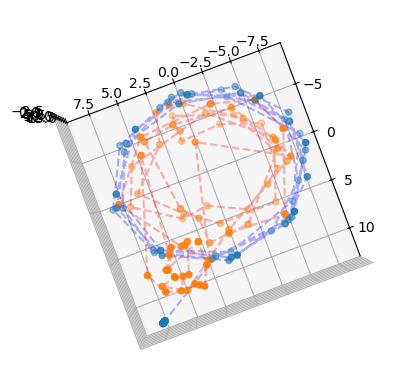

In [57]:
"""
Plot Results (Qualitative)
"""
X, Y, Z = 0, 1, 2
fig = plt.figure()
ax = plt.axes(projection='3d')

y_pred = best_rf.predict(X_unseen)

ax.scatter(y_unseen[:, X], y_unseen[:, Y], y_unseen[:, Z], 'blue')
ax.plot(y_unseen[:, X], y_unseen[:, Y], y_unseen[:, Z], color=(0., 0., 1., 0.3), linestyle='--')


ax.scatter(y_pred[:, X], y_pred[:, Y], y_pred[:, Z], 'red')
ax.plot(y_pred[:, X], y_pred[:, Y], y_pred[:, Z], color=(1., 0., 0., 0.3), linestyle='--')
ax.view_init(270, 20)
plt.show()

# Evaluation of Pressure and Kalman Filtering Based Positioning

## Height Kalman Filter Definition

In [24]:
# --------------------------------
# kalman filter
# --------------------------------
"""
State Vector

format:
    - [0:3] position z (meters global coords)
    - [6:9] velocity z (m/s global coords)
"""

# P (measurement cov mat)
P = np.identity(2) * .01
# Q (process noise)
Q = np.identity(2) * .1
# R (measurement noise)
R = np.identity(1) * 1.
# H (measurement matrix)
H = np.array([
    [ 1., 0. ], 
])

# function to get A (state transition matrix) for certain dt
def getA(dt: float):
    return np.array([
        [1., dt],  # Height
        [0., 1.]   # Velocity
    ])

# function to get B (control transition matrix) for certain dt
def getB(dt: float):
    return np.array([
        [0.5 * dt**2],  # Height
        [dt]            # Velocity
    ])


kf = HelixonKalmanFilter(getA, getB, P, Q)

## Qualitative and Quantitative Results Over 1 Sequence

In [25]:
# get data from hdf5
raw_timestamp, raw_9dof, raw_rpy, raw_bno, raw_bmp, raw_pressure, wifidata, gt_timestamp, gt_position, gt_orientation = readHDF5('RandomUDP6')

# convenience
Z = 2
N = len(raw_timestamp) 

# remove offsets gt pos and orientation
gt_position = np.array(gt_position)
gt_position -= gt_position[0]

# get sensor data
araw = np.array(raw_9dof[:, :3])
pres = np.array(raw_pressure).reshape((-1, 1))
alpha = 1.16e-4
ts = np.array(raw_timestamp)*1e-6
gt_timestamp = np.array(gt_timestamp)*1e-6

# define p0
p0 = np.mean(raw_pressure[:200])
pres[np.where(pres > p0)] = p0

# load accels
accel = np.array(araw)
global_accel_z = accel[:,Z].reshape(N, 1, 1)

# all ys (measurements) for kalman filter
heights = np.log(pres/p0)/(-alpha)
ys = heights

# all us (control inputs) for kalman filter
us = global_accel_z

kalman filter ATE: 0.15905948058493474 RTE: 0.29286569877992935
heights ATE: 0.1556463186868515 RTE: 0.2855659225646743


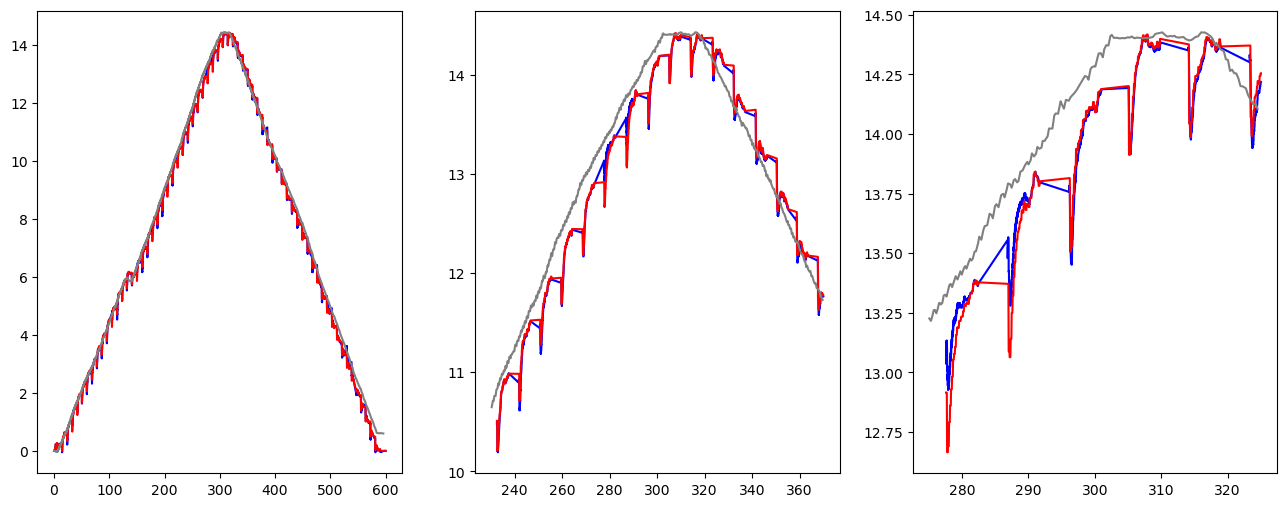

In [26]:
# Run Kalman Filter offline
predicted_heights = kf.run_offline(us, ys, H, R, ts)[:, 0].reshape(-1, 1)
predicted_positions = []
for height in predicted_heights:
    predicted_positions.append(Spiral.point_at_z(height))
predicted_positions = np.array(predicted_positions)

# ATE and RTE for heights only
ateKALMAN, rteKALMAN = compute_ate_rte(np.concatenate((np.array(ts).reshape((-1, 1)), predicted_heights*np.array([0, 0, 1])), axis=1), 
                                    np.concatenate((np.array(gt_timestamp).reshape((-1, 1)), gt_position*np.array([0, 0, 1])), axis=1))

ateH, rteH = compute_ate_rte(np.concatenate((np.array(ts).reshape((-1, 1)), heights*np.array([0, 0, 1])), axis=1), 
                        np.concatenate((np.array(gt_timestamp).reshape((-1, 1)), gt_position*np.array([0, 0, 1])), axis=1))

print(f'kalman filter ATE: {ateKALMAN} RTE: {rteKALMAN}\nheights ATE: {ateH} RTE: {rteH}')

# plot heights as functions of time
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
ax1.plot(ts, predicted_heights[:, 0], 'blue')
ax1.plot(ts, heights.flatten(), 'red')
ax1.plot(gt_timestamp, gt_position[:, 2], 'gray')

t_start, t_end = 230, 370 
ixraw_1 = np.argmax(ts > t_start)
ixraw_2 = ixraw_1 + np.argmax(ts[ixraw_1:] > t_end)
ixgt_1 = np.argmax(gt_timestamp > t_start)
ixgt_2 = ixgt_1 + np.argmax(gt_timestamp[ixgt_1:] > t_end)

ax2.plot(ts[ixraw_1:ixraw_2], predicted_heights[ixraw_1:ixraw_2, 0], 'blue')
ax2.plot(ts[ixraw_1:ixraw_2], heights.flatten()[ixraw_1:ixraw_2], 'red')
ax2.plot(gt_timestamp[ixgt_1:ixgt_2], gt_position[ixgt_1:ixgt_2, 2], 'gray')

t_start, t_end = 275, 325 
ixraw_1 = np.argmax(ts > t_start)
ixraw_2 = ixraw_1 + np.argmax(ts[ixraw_1:] > t_end)
ixgt_1 = np.argmax(gt_timestamp > t_start)
ixgt_2 = ixgt_1 + np.argmax(gt_timestamp[ixgt_1:] > t_end)

ax3.plot(ts[ixraw_1:ixraw_2], predicted_heights[ixraw_1:ixraw_2, 0], 'blue')
ax3.plot(ts[ixraw_1:ixraw_2], heights.flatten()[ixraw_1:ixraw_2], 'red')
ax3.plot(gt_timestamp[ixgt_1:ixgt_2], gt_position[ixgt_1:ixgt_2, 2], 'gray')
plt.show()

kalman filter ATE: 3.142034704083075 RTE: 2.2584136494674296


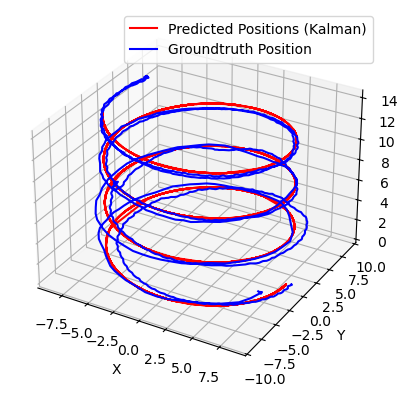

In [27]:
# Generating spiral from "raw heights"
predicted_positions = []
for height in predicted_heights:
    predicted_positions.append(Spiral.point_at_z(height))

predicted_positions = np.array(predicted_positions)

# Aligning spirals at (x, y) = (0, 0)
predicted_positions = Spiral.center_spiral(predicted_positions).reshape((-1, 3))
gt_position = Spiral.center_spiral(gt_position)

# ATE and RTE for predictions
ateKALMAN, rteKALMAN = compute_ate_rte(np.concatenate((np.array(ts).reshape((-1, 1)), predicted_positions), axis=1), 
                                    np.concatenate((np.array(gt_timestamp).reshape((-1, 1)), gt_position), axis=1))

print(f'kalman filter ATE: {ateKALMAN} RTE: {rteKALMAN}')

# Plotting predicted and gt spirals
fig = plt.figure()
ax = plt.axes(projection='3d')
predicted_positions = np.array(predicted_positions)  # Convert list to NumPy array
ax.plot3D(predicted_positions[:, 0], predicted_positions[:, 1], predicted_positions[:, 2], 'red', label='Predicted Positions (Kalman)')
ax.plot3D(gt_position[:, 0], gt_position[:, 1], gt_position[:, 2], 'blue', label='Groundtruth Position')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

## Full evaluation of performance over dataset